In [2]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [5]:
def get_bin_widths():
    h = 6.62607004e-34
    e = 1.60217662e-19
    freq_path = '/ptmp/mpa/mglatzle/TNG_f_esc/fid2/BB_T1d4_L2d38_r67_DUST.ps'
    freq = np.loadtxt(freq_path, skiprows=1)[1:,0]
    bin_widths = []
    centroids = []
    for i in range(len(freq)-1):
        bin_widths.append(freq[i+1]-freq[i])
        centroids.append(freq[i]/2+freq[i+1]/2)
    energies = np.array(centroids)*h/e    
    return (np.array(bin_widths)*h/e, energies)

In [6]:
def get_tot_photons(df,IDs=None,emitted=True):
    if IDs==None:
        IDs = df.index.values
    tot_photons = np.zeros(df.loc[IDs[0]]['emitted_photons'].shape[0])
    for ID in IDs:
        if emitted:
            photons = df.loc[ID]['emitted_photons']/df.loc[ID]['n_iterations']
        else:
            photons = df.loc[ID]['escaped_photons']/df.loc[ID]['n_iterations']
        photons_cum = photons.sum(axis=1)
        tot_photons += photons_cum
    return tot_photons

In [7]:
def get_spectrum(df, IDs=None, emitted=True):
    bin_widths, energies = get_bin_widths()
    tot_photons = get_tot_photons(df, IDs, emitted)
    tot_photons_norm = tot_photons/tot_photons.sum()
    spectrum = tot_photons_norm/bin_widths
    return (energies, bin_widths, spectrum)

### Function which plots the average or median frequency dependent escape fraction:
- **dataframes**: List of dataframes for which the escape fraction needs to be analysed
- **mode**: Do you want to take the mean or the average over the halo escape fractions
- **labels**: Labels for the graphs, by default they will be named 'dataframe n' where n is the number of the dataframe as it appears in the dataframes list

In [25]:
def freq_fesc(dataframes, mode='mean', labels=None, save=False):
    plt.rcParams["figure.figsize"] = (30,20)
    #Set natural constants to convert photon frequency to energy in eV
    h = 6.62607004e-34
    e = 1.60217662e-19
    if labels == None:
        labels=[]
        for i in range(len(dataframes)):
            labels.append(f'dataframe {i+1}')
    for i, dataframe in enumerate(dataframes):
        energies = dataframe.iloc[0]['frequencies']*h/e

        per_freq_data = np.vstack(dataframe.loc[:,'per_freq'].to_numpy())
        error = np.std(per_freq_data, axis=0)/np.sqrt(len(per_freq_data))

        if mode == 'mean':
            values = np.mean(per_freq_data, axis=0)
        elif mode == 'median':
            values = np.median(per_freq_data, axis=0)
        else:
            raise ValueError('The possible modes are "mean" and "median"')
        #plt.ylim(0,0.35)
        plt.errorbar(energies, values, yerr=error, linewidth=5, elinewidth=1, capsize=10, label=str(labels[i]))
    plt.xlabel(r'$E[\mathrm{eV}]$', fontsize = 65)
    plt.ylabel(r'$\langle f_{\mathrm{esc}} \rangle$', fontsize = 65)
    
    plt.rc('axes', linewidth=3)
    plt.rc('xtick', labelsize=35) 
    plt.rc('ytick', labelsize=35) 
    plt.legend(fontsize=50)
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/freq_fesc.pdf')
    plt.show()
    return 

In [167]:
def get_wavelength(energy):
    h = 6.62607004e-34
    e = 1.60217662e-19
    c = 299792458.
    return h*c/energy/e

def get_energy(wavelength):
    h = 6.62607004e-34
    e = 1.60217662e-19
    c = 299792458.
    return h*c/wavelength/e

In [211]:
def plot_multiple_spectra_comparison(dfs, colors=None, labels=None, save=False):
    if colors==None:
        colors=['b','g','r', 'c','m','y']
    if labels==None:
        labels=[x for x in range(len(dfs))]
    for i, df in enumerate(dfs):
        energies, widths, spec_em = get_spectrum(df, IDs=None, emitted=True)
        energies, widths, spec_es = get_spectrum(df, IDs=None, emitted=False)
        ax = plt.gca()
        ax.plot(energies, spec_em, label=f'{labels[i]} emitted', linewidth=3, color=colors[i])
        ax.plot(energies, spec_es, label=f'{labels[i]} escaped', linewidth=3, color=colors[i], linestyle='dashed')
    secax = ax.secondary_xaxis('top', functions=(get_wavelength, get_energy))
    secax.set_xlabel(r'$\lambda$ [m]', fontsize=55)
    secax.tick_params(length=16, width=4)
    secax.tick_params(length=8, width=3, which='minor')
    #y_ticks = np.arange(10, 16, 2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    ax.set_xlabel('$E_\gamma[\mathrm{eV}]$', fontsize=55)
    ax.set_ylabel('$P(\gamma)$', fontsize=55)
    ax.legend(fontsize=37)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.rc('axes', linewidth=3)
    plt.tick_params(length=16, width=4)
    plt.tick_params(length=8, width=3, which='minor')
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/spectra_comparison.pdf')

    return

In [180]:
def plot_spectra_comparison(df, IDs=None, save=False):
    energies, widths, spec_em = get_spectrum(df, IDs=IDs, emitted=True)
    energies, widths, spec_es = get_spectrum(df, IDs=IDs, emitted=False)
    ax = plt.gca()
    ax.plot(energies, spec_em, label='emitted spectrum', linewidth=3)
    ax.plot(energies, spec_es, label='escaped spectrum', linewidth=3)
    secax = ax.secondary_xaxis('top', functions=(get_wavelength, get_energy))
    secax.set_xlabel(r'$\lambda$ [m]', fontsize=55)
    secax.tick_params(length=16, width=4)
    secax.tick_params(length=8, width=3, which='minor')
    #y_ticks = np.arange(10, 16, 2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    ax.set_xlabel('$E_\gamma[\mathrm{eV}]$', fontsize=55)
    ax.set_ylabel('$P(\gamma)$', fontsize=55)
    ax.legend(fontsize=37)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.rc('axes', linewidth=3)
    plt.tick_params(length=16, width=4)
    plt.tick_params(length=8, width=3, which='minor')
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/spectra.pdf')

    return

In [28]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

In [29]:
df = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
update_df(df)

In [206]:
filt_f_esc = df.f_esc > 0.1
filt_f_esc_small = df.f_esc < 0.01
filt_star = df.StarMass > 100
filt_star_small = df.StarMass < 1
dfs=[df[filt_f_esc],df[filt_f_esc_small], df[filt_star], df[filt_star_small]]
labels = [r'$f_\mathrm{esc}>0.1$',r'$f_\mathrm{esc}<0.01$',r'$M_\mathrm{star}>10^8$',r'$M_\mathrm{star}<10^6$']

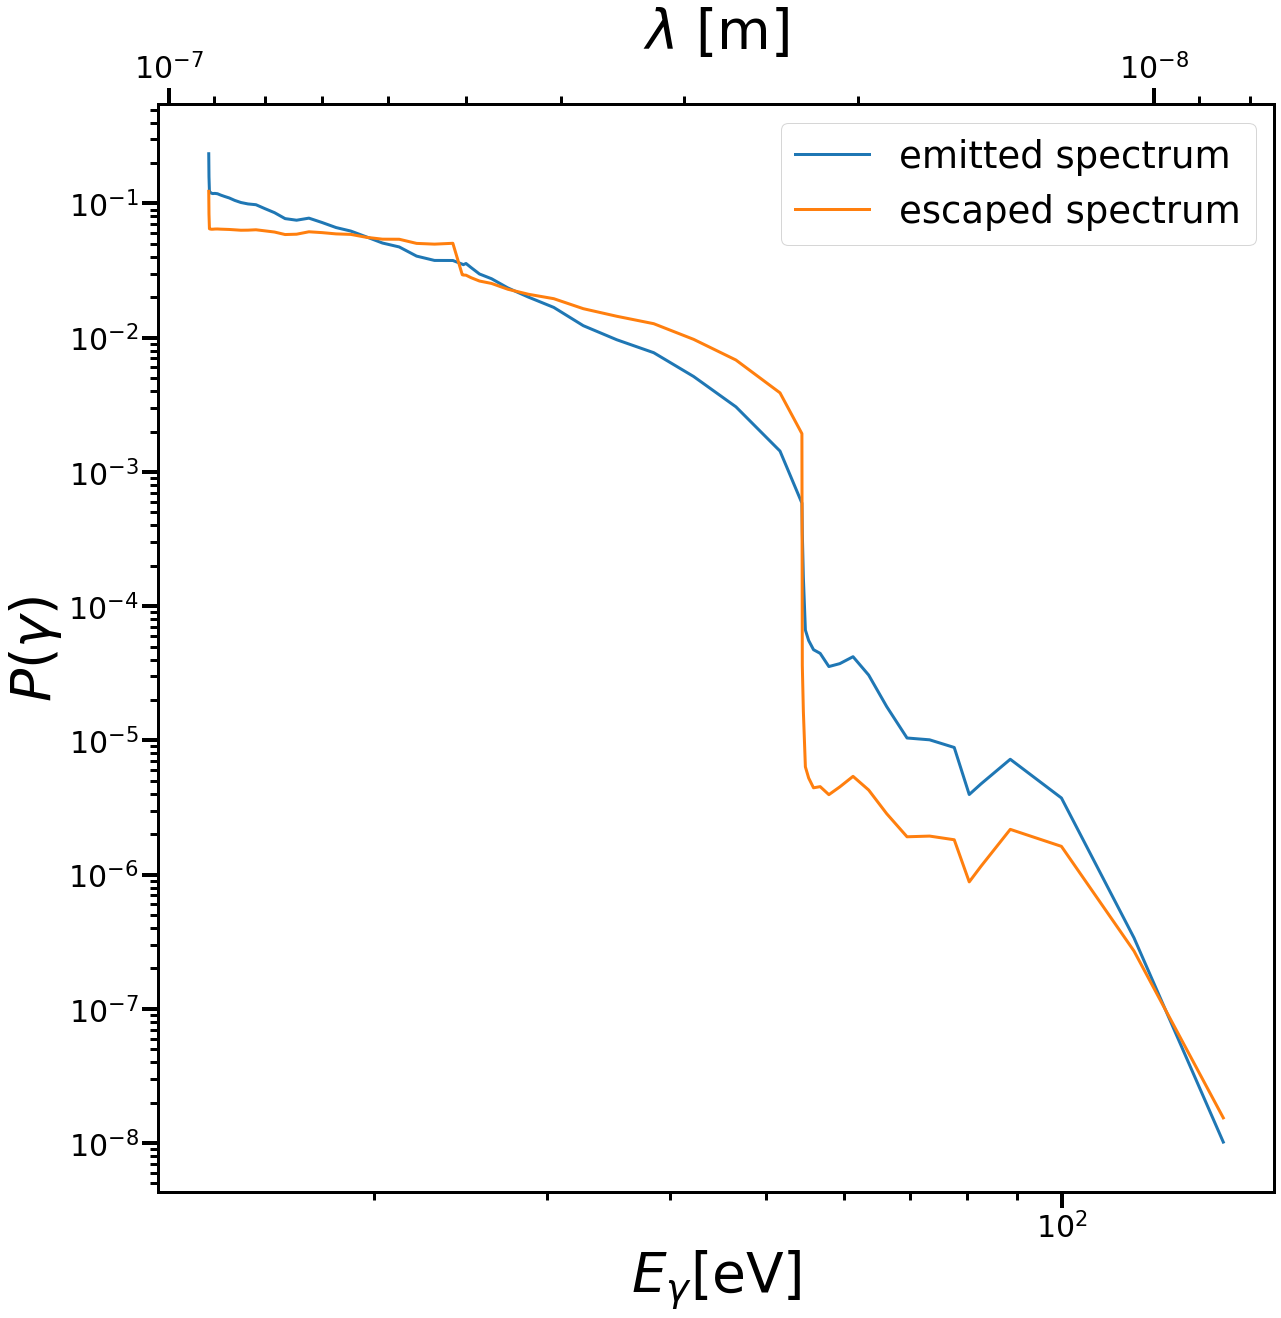

In [183]:
plot_spectra_comparison(df, save=True)

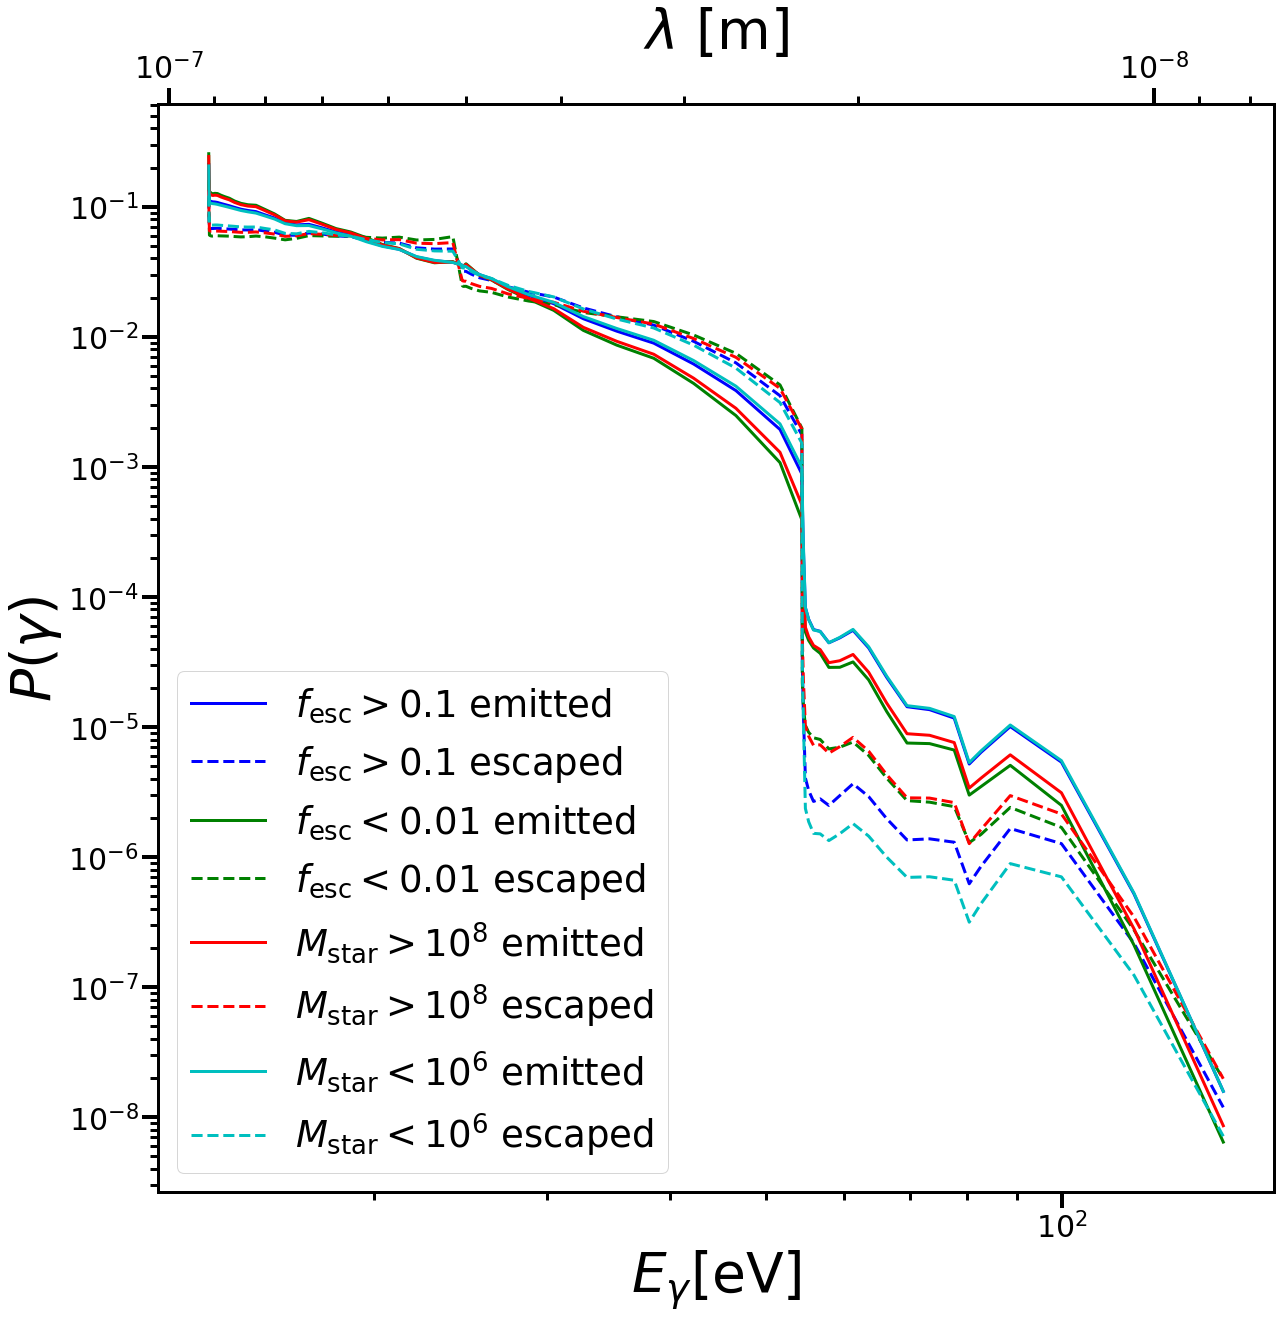

In [212]:
plot_multiple_spectra_comparison(dfs, colors=None, labels=labels, save=True)

In [88]:
df_6 = df[df.z==6]
df_8 = df[df.z==8]
df_10 = df[df.z==10]
dfs=[df_6, df_8, df_10]
labels = ['z=6','z=8','z=10']

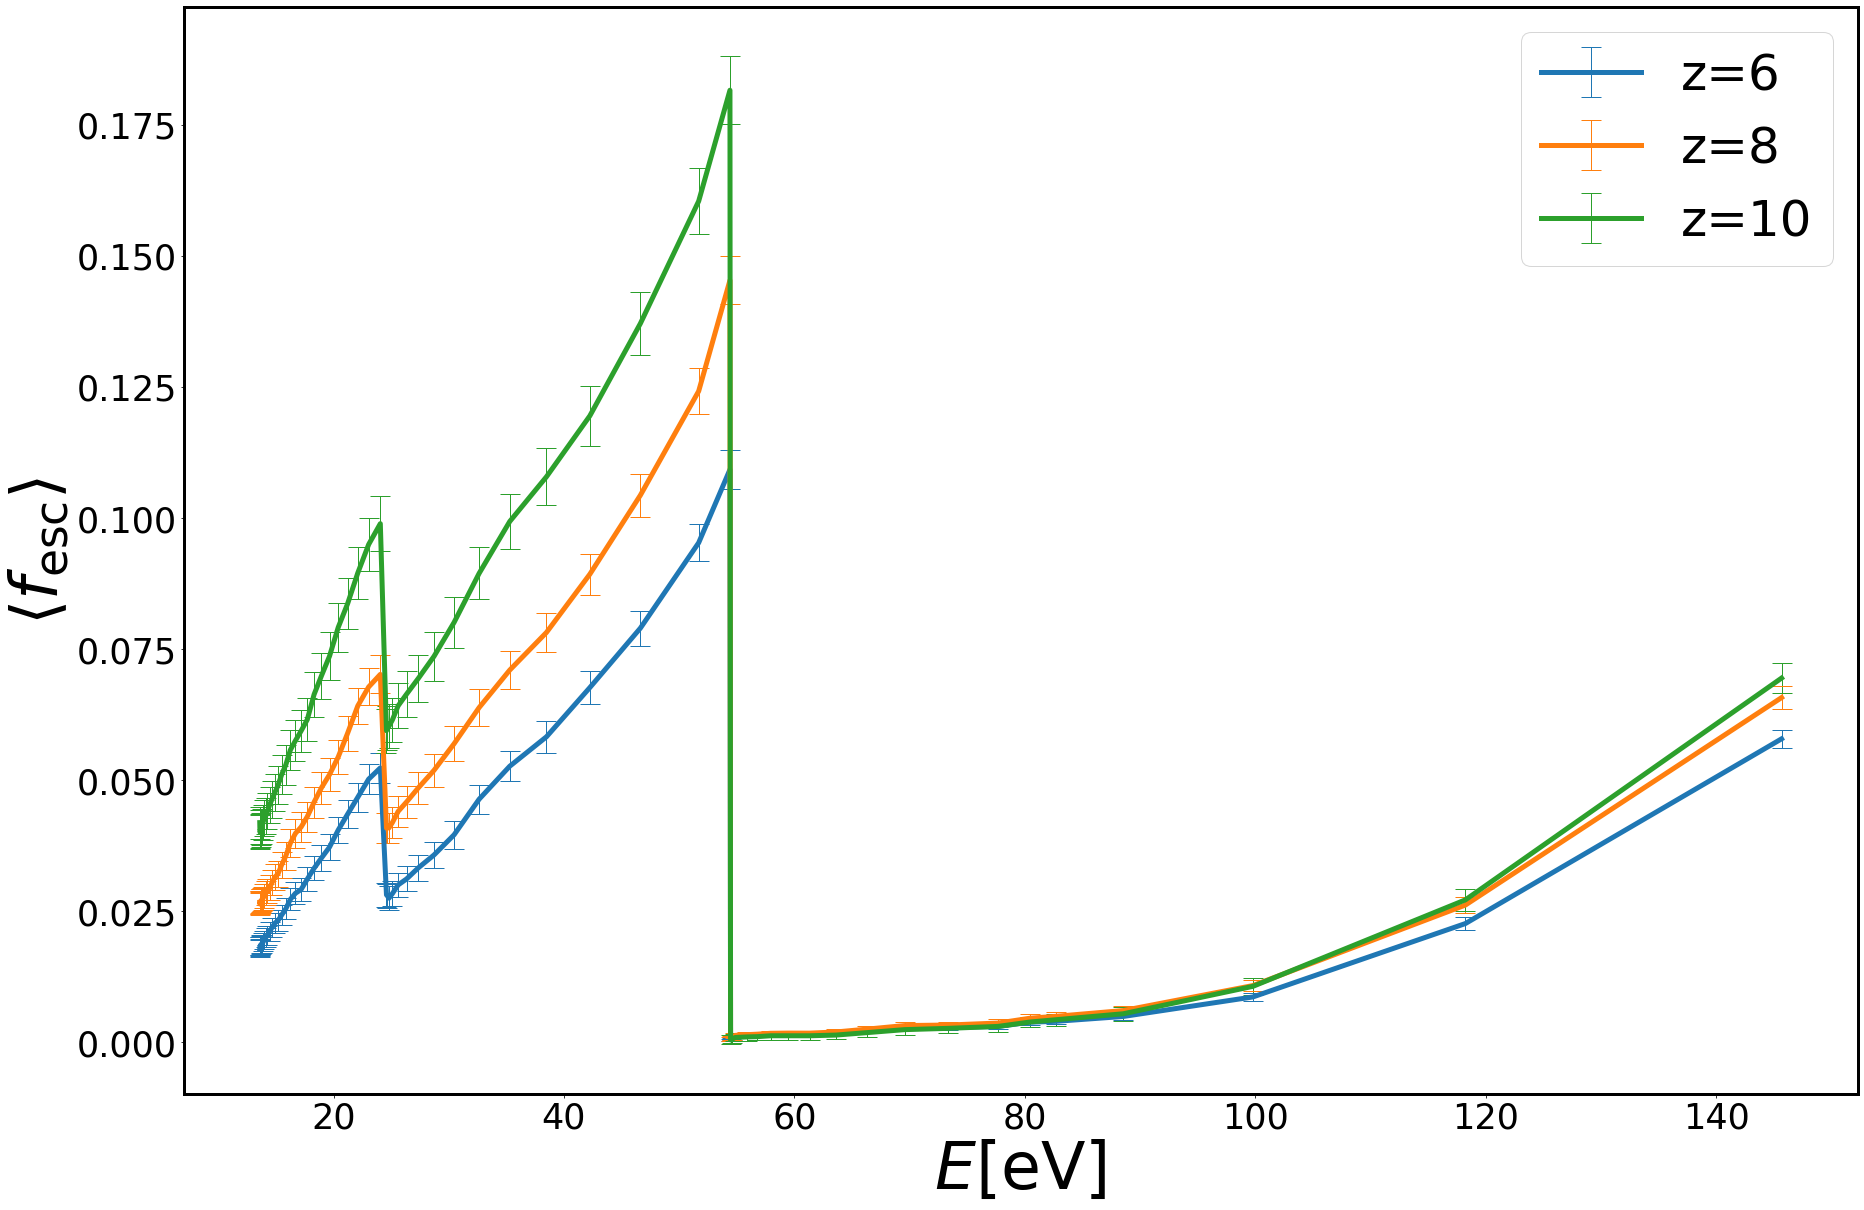

In [26]:
freq_fesc(dfs, mode='median', labels=labels, save=True)